In [ ]:
# РАДИКАЛЬНОЕ ПОДАВЛЕНИЕ ВСЕХ ПРЕДУПРЕЖДЕНИЙ
import sys
import warnings
import os

# Полное отключение всех предупреждений
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r".*datetime\.datetime\.utcnow\(\) is deprecated.*"
)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS'] = 'ignore::DeprecationWarning'

# Перенаправление stderr в null
class SuppressStderr:
    def __enter__(self):
        self._original_stderr = sys.stderr
        self._original_stdout = sys.stdout
        sys.stderr = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self._original_stderr
        sys.stdout = self._original_stdout

# Применяем подавление для установки библиотек
with SuppressStderr():
    # Установка библиотек
    !pip install -U gensim pyLDAvis pymorphy3 nltk -q > /dev/null 2>&1
    # !pip install -U gensim pymorphy3 nltk -q > /dev/null 2>&1

    # Импорт библиотек внутри контекста подавления
    import re
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from tqdm.notebook import tqdm

    import nltk
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords

    import pymorphy3
    from gensim import corpora, models
    from gensim.models import CoherenceModel, LdaModel
    # import pyLDAvis
    # # import pyLDAvis.gensim as gensimvis
    # import pyLDAvis.gensim_models as gensimvis  # ИЗМЕНЕНИЕ: используем gensim_models вместо gensim


# Теперь импортируем еще раз вне контекста, чтобы иметь доступ к библиотекам
# Но это безопасно, так как основные предупреждения возникают при импорте
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
import pymorphy3
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis
import pyLDAvis.gensim as gensimvis

print("Библиотеки загружены успешно")

Библиотеки загружены успешно


In [ ]:
morph = pymorphy3.MorphAnalyzer()

# Загрузка данных
# Предполагается, что файл resumes.csv лежит в рабочей директории Colab
df = pd.read_csv('resumes.csv')

# Проверим структуру
print("Первые 3 записи:")
df.head(3)

Первые 3 записи:


,ФИО,Желаемая должность,Зарплата,Личная информация,Местоположение,Занятость и график,Общий опыт,Последнее место работы,Обязанности,Ключевые навыки,Обо мне,Образование,Языки,Ссылка
0,Candidate,Developer 1C,Не указано,"Male, 35 years","Baku , willing to relocate (Moscow) , prepared...",Не указано,Work experience 7 years 10 months,Developer 1C в İrşad,-Making changes in existing modules and prepar...,"C/C++, Python, SQL, PHP HTML CSS, SAP, TCP/IP ...",Не указано,"Moscow Lomonosov State University, Moscow (Rus...","Azerbaijani — Native, English — B2 — Upper Int...",https://hh.ru/resume/fa6d377200053077150039ed1...
1,Кандидат,Разработчик 1С,Не указано,"Мужчина, 52 года","Москва , не готов к переезду , не готов к кома...",Не указано,Опыт работы 24 года 1 месяц,Вед.разработчик в ООО Сигма,Развитие и доработка собственных бизнес-прилож...,"Исполнительность, Русский — Родной, Английский...","Спорт, автомобили,экономика.","МГТУ им. Баумана МТ , Инженер-механик электрон...","Русский — Родной, Английский — A1 — Начальный,...",https://hh.ru/resume/6654bee700023a3d750039ed1...
2,Кандидат,Ведущий программист 1C,350 000 ₽ на руки,"Мужчина, 35 лет","Москва , готов к переезду , готов к командировкам",Не указано,Опыт работы 12 лет 7 месяцев,Программист 1C в Первый БИТ,Большой опыт разработки на управляемых формах ...,"Русский — Родной, Английский — B2 — Средне-про...","Аналитический склад ума, внимательный, ответст...",Московский государственный технический универс...,"Русский — Родной, Английский — B2 — Средне-про...",https://hh.ru/resume/0fd9a67b00058c45400039ed1...


In [ ]:
# Объединим три поля в одно текстовое поле для анализа
text_fields = ['Последнее место работы', 'Обязанности', 'Ключевые навыки']

# Заменим NaN на пустые строки и объединим
for col in text_fields:
    df[col] = df[col].fillna('')

df['text'] = df[text_fields].apply(lambda x: ' '.join(x), axis=1)

# Оставим только нужные столбцы
data = df[['Желаемая должность', 'text']].copy()
data.columns = ['position', 'text']

# Удалим строки без текста или должности
data.dropna(subset=['position', 'text'], inplace=True)
data = data[data['text'].str.strip() != '']
data.reset_index(drop=True, inplace=True)

print(f"\nВсего резюме после очистки: {len(data)}")


Всего резюме после очистки: 100


In [ ]:
df.head(3)

,ФИО,Желаемая должность,Зарплата,Личная информация,Местоположение,Занятость и график,Общий опыт,Последнее место работы,Обязанности,Ключевые навыки,Обо мне,Образование,Языки,Ссылка,text
0,Candidate,Developer 1C,Не указано,"Male, 35 years","Baku , willing to relocate (Moscow) , prepared...",Не указано,Work experience 7 years 10 months,Developer 1C в İrşad,-Making changes in existing modules and prepar...,"C/C++, Python, SQL, PHP HTML CSS, SAP, TCP/IP ...",Не указано,"Moscow Lomonosov State University, Moscow (Rus...","Azerbaijani — Native, English — B2 — Upper Int...",https://hh.ru/resume/fa6d377200053077150039ed1...,Developer 1C в İrşad -Making changes in existi...
1,Кандидат,Разработчик 1С,Не указано,"Мужчина, 52 года","Москва , не готов к переезду , не готов к кома...",Не указано,Опыт работы 24 года 1 месяц,Вед.разработчик в ООО Сигма,Развитие и доработка собственных бизнес-прилож...,"Исполнительность, Русский — Родной, Английский...","Спорт, автомобили,экономика.","МГТУ им. Баумана МТ , Инженер-механик электрон...","Русский — Родной, Английский — A1 — Начальный,...",https://hh.ru/resume/6654bee700023a3d750039ed1...,Вед.разработчик в ООО Сигма Развитие и доработ...
2,Кандидат,Ведущий программист 1C,350 000 ₽ на руки,"Мужчина, 35 лет","Москва , готов к переезду , готов к командировкам",Не указано,Опыт работы 12 лет 7 месяцев,Программист 1C в Первый БИТ,Большой опыт разработки на управляемых формах ...,"Русский — Родной, Английский — B2 — Средне-про...","Аналитический склад ума, внимательный, ответст...",Московский государственный технический универс...,"Русский — Родной, Английский — B2 — Средне-про...",https://hh.ru/resume/0fd9a67b00058c45400039ed1...,Программист 1C в Первый БИТ Большой опыт разра...


In [ ]:
# Посмотрим на распределение желаемых должностей
print("\nТоп-15 желаемых должностей:")
print(data['position'].value_counts().head(15))


Топ-15 желаемых должностей:
position
Java-разработчик                                13
Python-разработчик                               7
Программист 1C                                   6
Программист 1С                                   4
C# разработчик                                   4
Python Developer                                 4
C# Developer                                     3
C#/.NET-разработчик                              3
Программист-разработчик                          3
Python разработчик                               3
Программист C#                                   2
Разработчик 1С                                   2
Go разработчик                                   2
Разработчик 1С\Архитектор 1С\ Программист 1С     1
FullStack Developer                              1
Name: count, dtype: int64


In [ ]:
"""
### Предобработка текста

Как и в случае с новостями, проведём:
- токенизацию,
- фильтрацию по длине и алфавиту,
- лемматизацию,
- удаление стоп-слов.
"""

# Регулярное выражение для извлечения слов
words_regex = re.compile(r'\w+')

def find_words(text, regex=words_regex):
    tokens = regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

# Стоп-слова
stopwords_list = set(stopwords.words('russian'))
# Добавим типичные "мусорные" слова из резюме
extra_stops = {'это', 'который', 'свой', 'такой', 'очень', 'также', 'например', 'работа', 'опыт', 'год', 'лет', 'команда', 'проект', 'обязанности', 'разработка', 'разработчик', 'английский'}
stopwords_list.update(extra_stops)

def lemmatize(words, lemmer=morph, stopwords=stopwords_list):
    lemmas = []
    for w in words:
        try:
            lemma = lemmer.parse(w)[0].normal_form
            if lemma not in stopwords and lemma.isalpha():
                lemmas.append(lemma)
        except:
            continue
    return lemmas

def preprocess(text):
    return lemmatize(find_words(text))

# Пример предобработки
print("\nПример текста до обработки:")
print(data['text'].iloc[0][:200])


print("\nПосле предобработки:")
print(preprocess(data['text'].iloc[0]))


Пример текста до обработки:
Developer 1C в İrşad -Making changes in existing modules and preparing new modules, reports according to requirements. -Installation, configuration and administration of 1C servers. Backup and restore

После предобработки:
['developer', 'rşad', 'making', 'changes', 'existing', 'modules', 'and', 'preparing', 'new', 'modules', 'reports', 'according', 'requirements', 'installation', 'configuration', 'and', 'administration', 'servers', 'backup', 'and', 'restore', 'data', 'python', 'sql', 'php', 'html', 'css', 'sap', 'tcp', 'dhcp', 'dns', 'development', 'windows', 'server', 'develop', 'azerbaijani', 'native', 'english', 'upper', 'intermediate', 'russian', 'proficiency']


In [ ]:
# Предобработка всего корпуса
print("\nПредобработка всех текстов...")
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

data['text'] = preprocessed_text
data.sample(3)


Предобработка всех текстов...


  0%|          | 0/100 [00:00<?, ?it/s]

,position,text
69,Java-разработчик,"[java, сбер, микросервис, java, использование,..."
75,Java developer,"[java, консалтинг, работать, java, core, java,..."
64,Java-разработчик,"[java, корусый, консалтинг, снг, back, java, j..."


In [ ]:
"""
## Модель LDA
"""

from gensim import corpora
from gensim.models import ldamodel
from gensim.models.coherencemodel import CoherenceModel

# Создание словаря
dictionary = corpora.Dictionary(data['text'])

In [ ]:
# Фильтрация редких и слишком частых слов
dictionary.filter_extremes(no_below=10, no_above=0.9)
print(f"\nРазмер словаря после фильтрации: {len(dictionary)}")

# Сохранение словаря
dictionary.save('resumes.dict')


Размер словаря после фильтрации: 107


In [ ]:
# Векторизация корпуса (BOW)
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('resumes.mm', corpus)

In [ ]:
"""
Обучение LDA с num_topics=5 (по числу исходных должностей)
"""
print("\nОбучение LDA (5 тем)...")
lda = ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    chunksize=50,
    update_every=1,
    passes=2,
    random_state=42
)

# Показать темы с весами
# print("\nНайденные темы (5) с весами:")
# for idx, topic in lda.show_topics(num_topics=5, num_words=10, formatted=False):
#     print(f"\nТема {idx}:")
#     for weight, word in topic:
#         print(f"  {word}: {weight:.4f}")
lda.show_topics(num_topics=10, num_words=10, formatted=True)



Обучение LDA (5 тем)...


[(0,
  '0.114*"python" + 0.047*"git" + 0.047*"sql" + 0.040*"postgresql" + 0.036*"api" + 0.032*"linux" + 0.030*"docker" + 0.027*"framework" + 0.022*"golang" + 0.021*"bash"'),
 (1,
  '0.054*"net" + 0.039*"система" + 0.037*"конфигурация" + 0.036*"настройка" + 0.032*"база" + 0.032*"asp" + 0.031*"управление" + 0.031*"создание" + 0.030*"поддержка" + 0.027*"sql"'),
 (2,
  '0.057*"сервис" + 0.047*"новый" + 0.038*"система" + 0.038*"процесс" + 0.033*"создание" + 0.029*"программирование" + 0.029*"технический" + 0.029*"внедрение" + 0.026*"данные" + 0.025*"программист"'),
 (3,
  '0.121*"java" + 0.099*"spring" + 0.040*"postgresql" + 0.033*"данные" + 0.031*"framework" + 0.030*"apache" + 0.029*"boot" + 0.026*"технология" + 0.024*"sql" + 0.024*"hibernate"'),
 (4,
  '0.055*"rest" + 0.046*"api" + 0.040*"сервис" + 0.040*"redis" + 0.038*"clickhouse" + 0.036*"docker" + 0.034*"django" + 0.030*"postgresql" + 0.030*"код" + 0.027*"git"')]

In [ ]:
!pip install pyLDAvis --quiet

In [ ]:

# Визуализация через pyLDAvis — РАБОТАЕТ В COLAB
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# from IPython.display import HTML, IFrame
import pyLDAvis
import pyLDAvis.gensim as gensimvis




In [ ]:
# print("\nПодготовка визуализации...")
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)


# # Подготовка данных для визуализации
# vis_data = gensimvis.prepare(lda, corpus, dictionary)

# # Сохраняем в HTML
# pyLDAvis.save_html(vis_data, 'lda_initial.html')
# print("Визуализация сохранена как 'lda_initial.html'")

# # Отображаем в Colab
# HTML(filename='lda_initial.html')

# # --- Визуализация начальной модели (5 тем) ---
# vis_data = gensimvis.prepare(lda, corpus, dictionary)
# pyLDAvis.save_html(vis_data, 'lda_initial.html')
# print("\n✅ Начальная визуализация (5 тем) сохранена.")
# from IPython.display import display, HTML
# display(HTML(open('lda_initial.html', 'r', encoding='utf-8').read()))

# """
# ВИЗУАЛИЗАЦИЯ ТЕМ С ПОМОЩЬЮ ГРАФИКОВ - ЗАМЕНА pyLDAvis
# """

# print("\n" + "="*60)
# print("ВИЗУАЛИЗАЦИЯ 5 ТЕМ С ПОМОЩЬЮ ГРАФИКОВ")
# print("="*60)

# # Визуализация 5 тем
# for i, topic in lda.show_topics(num_topics=5, num_words=10, formatted=False):
#     words, weights = zip(*topic)

#     plt.figure(figsize=(10, 6))
#     bars = plt.barh(words, weights, color='lightblue', edgecolor='black')
#     plt.gca().invert_yaxis()
#     plt.title(f'Тема {i}: Топ-10 ключевых слов', fontsize=14, fontweight='bold')
#     plt.xlabel('Вес слова', fontsize=12)
#     plt.ylabel('Ключевые слова', fontsize=12)
#     plt.grid(axis='x', linestyle='--', alpha=0.7)

#     # Добавляем значения весов на график
#     for bar, weight in zip(bars, weights):
#         plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
#                 f'{weight:.4f}', ha='left', va='center', fontsize=9)

#     plt.tight_layout()
#     plt.show()

In [ ]:
"""
Оценка качества модели
"""
perplexity = lda.log_perplexity(corpus)
print(f"\nЛог-перплексия: {perplexity:.2f}")
print(f"Перплексия: {np.exp(perplexity):.2f}")

coherence_model = CoherenceModel(
    model=lda,
    texts=data['text'],
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Средняя когерентность (c_v): {coherence_score:.4f}")



Лог-перплексия: -4.55
Перплексия: 0.01
Средняя когерентность (c_v): 0.4944



Поиск оптимального числа тем...


  0%|          | 0/8 [00:00<?, ?it/s]

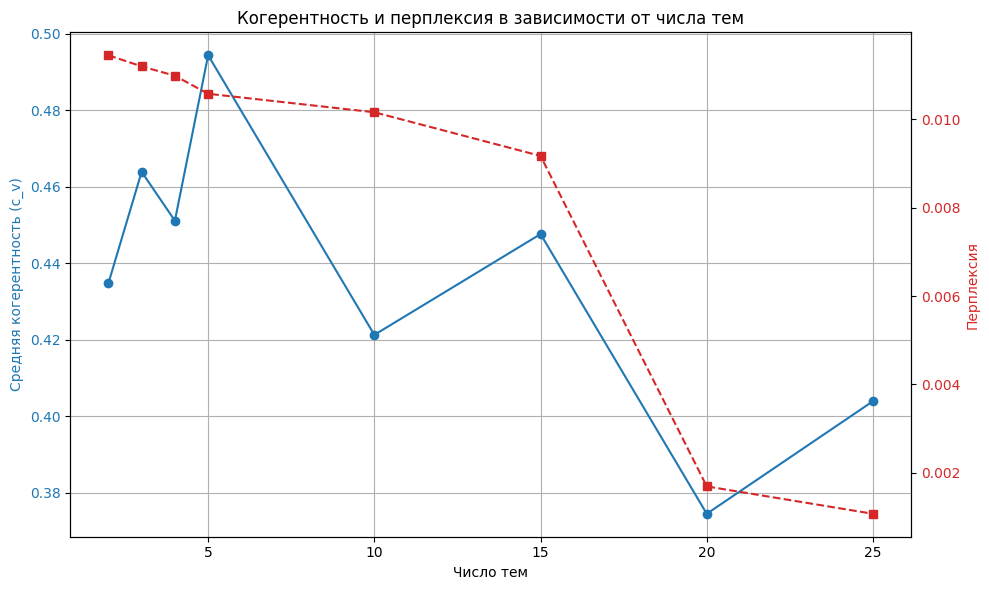


Лучшее число тем по когерентности: 5
Когерентность: 0.4944
Перплексия при этом числе тем: 0.01


In [ ]:
"""
Подбор оптимального числа тем: когерентность и перплексия
"""
print("\nПоиск оптимального числа тем...")

topics_list = [2,3,4,5, 10, 15, 20, 25]
coherences = []
perplexities = []

for num in tqdm(topics_list):
    lda_temp = ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num,
        chunksize=50,
        update_every=1,
        passes=2,
        random_state=42
    )
    # Когерентность
    cm = CoherenceModel(
        model=lda_temp,
        texts=data['text'],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherences.append(cm.get_coherence())

    # Перплексия
    perplexity = np.exp(lda_temp.log_perplexity(corpus))
    perplexities.append(perplexity)

# Графики: когерентность и перплексия
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Число тем")
ax1.set_ylabel("Средняя когерентность (c_v)", color=color)
ax1.plot(topics_list, coherences, marker='o', color=color, label="Когерентность")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # вторая ось Y
color = 'tab:red'
ax2.set_ylabel("Перплексия", color=color)
ax2.plot(topics_list, perplexities, marker='s', color=color, linestyle='--', label="Перплексия")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Когерентность и перплексия в зависимости от числа тем")
fig.tight_layout()
plt.show()

# Вывод лучшего числа тем по когерентности
best_num_topics = topics_list[np.argmax(coherences)]
print(f"\nЛучшее число тем по когерентности: {best_num_topics}")
print(f"Когерентность: {max(coherences):.4f}")
print(f"Перплексия при этом числе тем: {perplexities[np.argmax(coherences)]:.2f}")

In [ ]:
# Обучим финальную модель с лучшим числом тем (например, 15)
best_num_topics = topics_list[np.argmax(coherences)]
print(f"\nЛучшее число тем по когерентности: {best_num_topics}")

lda_best = ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num_topics,
    chunksize=50,
    update_every=1,
    passes=2,
    random_state=42
)




Лучшее число тем по когерентности: 5


In [ ]:
# Финальная визуализация
vis_best = gensimvis.prepare(lda_best, corpus, dictionary)
pyLDAvis.display(vis_best)

# # Финальная визуализация
# vis_best = gensimvis.prepare(lda_best, corpus, dictionary)
# pyLDAvis.save_html(vis_best, 'lda_best.html')
# print(f"Финальная визуализация ({best_num_topics} тем) сохранена как 'lda_best.html'")
# HTML(filename='lda_best.html')

# # --- Финальная визуализация ---
# vis_best = gensimvis.prepare(lda_best, corpus, dictionary)
# pyLDAvis.save_html(vis_best, 'lda_best.html')
# print(f"\n✅ Финальная визуализация ({best_num_topics} тем) сохранена.")
# display(HTML(open('lda_best.html', 'r', encoding='utf-8').read()))

# # Визуализация тем из лучшей модели
# print(f"\nВизуализация {best_num_topics} тем (лучшая модель по когерентности):")

# for i, topic in lda_best.show_topics(num_topics=best_num_topics, num_words=10, formatted=False):
#     words, weights = zip(*topic)

#     plt.figure(figsize=(10, 6))
#     bars = plt.barh(words, weights, color='lightgreen', edgecolor='black')
#     plt.gca().invert_yaxis()
#     plt.title(f'Тема {i}: Топ-10 ключевых слов', fontsize=14, fontweight='bold')
#     plt.xlabel('Вес слова', fontsize=12)
#     plt.ylabel('Ключевые слова', fontsize=12)
#     plt.grid(axis='x', linestyle='--', alpha=0.7)

#     # Добавляем значения весов на график
#     for bar, weight in zip(bars, weights):
#         plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
#                 f'{weight:.4f}', ha='left', va='center', fontsize=9)

#     plt.tight_layout()
#     plt.show()

# # Дополнительно: выведем все темы в текстовом виде для удобства
# print(f"\nТекстовое представление {best_num_topics} тем:")
# for i, topic in lda_best.show_topics(num_topics=best_num_topics, num_words=10, formatted=True):
#     print(f"Тема {i}: {topic}")

Тема 4 Тема 1 Тема 3 Тема 2


In [ ]:
lda_best.show_topics(num_topics=best_num_topics, num_words=10, formatted=True)

[(0,
  '0.114*"python" + 0.047*"git" + 0.047*"sql" + 0.040*"postgresql" + 0.036*"api" + 0.032*"linux" + 0.030*"docker" + 0.027*"framework" + 0.022*"golang" + 0.021*"bash"'),
 (1,
  '0.054*"net" + 0.039*"система" + 0.037*"конфигурация" + 0.036*"настройка" + 0.032*"база" + 0.032*"asp" + 0.031*"управление" + 0.031*"создание" + 0.030*"поддержка" + 0.027*"sql"'),
 (2,
  '0.057*"сервис" + 0.047*"новый" + 0.038*"система" + 0.038*"процесс" + 0.033*"создание" + 0.029*"программирование" + 0.029*"технический" + 0.029*"внедрение" + 0.026*"данные" + 0.025*"программист"'),
 (3,
  '0.121*"java" + 0.099*"spring" + 0.040*"postgresql" + 0.033*"данные" + 0.031*"framework" + 0.030*"apache" + 0.029*"boot" + 0.026*"технология" + 0.024*"sql" + 0.024*"hibernate"'),
 (4,
  '0.055*"rest" + 0.046*"api" + 0.040*"сервис" + 0.040*"redis" + 0.038*"clickhouse" + 0.036*"docker" + 0.034*"django" + 0.030*"postgresql" + 0.030*"код" + 0.027*"git"')]